# Capstone Project Code - Draft Version
### Produced by Thomas Reimer

Import relevant packages:

In [58]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analysis
import json # library to handle JSON files
from math import sin, cos, sqrt, atan2, radians
from geopy.geocoders import Nominatim 
import folium
import shapely.geometry
from pyproj import Transformer
import requests 
import os
import time
import matplotlib.pyplot as plt # plotting library

#from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

#from sklearn.cluster import KMeans
#from sklearn.datasets.samples_generator import make_blobs

#from bs4 import BeautifulSoup

print('Libraries imported.')

Libraries imported.


## Locations Setup

The analysis will focus on central London - let's identify the lat/long for the centre, and the corresponding address

In [21]:
london_address = 'London, UK'

geolocator = Nominatim(user_agent="london_addresses")
location = geolocator.geocode(london_address)
london_lat = location.latitude
london_lon = location.longitude
print('The geograpical coordinate of London are {}, {}.'.format(london_lat, london_lon))
address_check = geolocator.reverse([london_lat, london_lon], addressdetails=False)
print ('The centre of London is at: {}'.format(address_check))

The geograpical coordinate of London are 51.5073219, -0.1276474.
The centre of London is at: Charles I, Charing Cross, Westminster, Covent Garden, London, Greater London, England, SW1, United Kingdom


Let's make a function to measure distance (in kms) from a lat/long to central London

In [22]:
earth_radius = 6371.0

def dist_to_london_centre(latitude, longitude): #in Kms
    
    # compare lat longs with london centre, in radians
    dlat = radians(london_lat) - radians(latitude)
    dlon = radians(london_lon) - radians(longitude)
    
    # use trig to calculate distance
    a = sin(dlat / 2)**2 + cos(radians(51.5074)) * cos(radians(latitude)) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    
    distance = earth_radius * c

    return distance

Let's import some post code area data, which we might use for this analysis:

In [23]:
filename = os.getcwd() + '/data/postcode-outcodes.csv'
pcData = pd.read_csv(filename)

Let's filter down to the locations that we consider to be "central" London - arbitrarily 4km from the centre

In [24]:
for i in pcData.index:
    dist = dist_to_london_centre(pcData['latitude'][i],pcData['longitude'][i])

    pcData.at[i,'distanceToCentreLondon'] = dist
    pcData.at[i,'centralLondon'] = dist < 4  

pcData = pcData[pcData.centralLondon]

pcData.head()

,id,postcode,latitude,longitude,distanceToCentreLondon,centralLondon
747,749,EC1,51.52286,-0.10144,2.504771,True
748,750,EC1A,51.52019,-0.10300,2.226300,True
749,751,EC1M,51.52106,-0.10152,2.366938,True
750,752,EC1N,51.52026,-0.10732,2.012056,True
751,753,EC1R,51.52475,-0.10713,2.402318,True


We are also going to explore defining our own locations grid, which is easier to define in a standard (x, y) plane. Let's create the relevant transformers and check we are consistent when transforming from lat/long to (x, y) and back

In [25]:
transform_lltoxy = Transformer.from_crs("EPSG:4326", "EPSG:32630", always_xy=True)
transform_xytoll = Transformer.from_crs("EPSG:32630", "EPSG:4326", always_xy=True) 

print('Coordinate transformation check')
print('-------------------------------')
print('London center longitude={}, latitude={}'.format(london_lon, london_lat))
x, y = transform_lltoxy.transform(london_lon, london_lat)
print('London center X={}, Y={}'.format(x, y))
lo, la = transform_xytoll.transform(x, y)
print('London center longitude={}, latitude={}'.format(lo, la))

Coordinate transformation check
-------------------------------
London center longitude=-0.1276474, latitude=51.5073219
London center X=699327.1629885819, Y=5710155.49053811
London center longitude=-0.12764740000000097, latitude=51.5073219


We will also need to measure distances in the (x, y) space, so we create the relevant function

In [26]:
def calc_xy_distance(x1, y1, x2, y2):
    dx = x2 - x1
    dy = y2 - y1
    return sqrt(dx*dx + dy*dy)

Now, let's set up our grid of locations, which will have a radius of 500m and be equally spaced within 4km of the centre of london

In [27]:
london_x, london_y = transform_lltoxy.transform(london_lon, london_lat)

r=500
count = 11

x_step = 2*r
x_min = london_x - ((count-1)/2)*x_step

y_step = sqrt(3)*r
y_min = london_y - ((count-1)/2)*y_step

latitudes = []
longitudes = []
distances_from_center = []
xs = []
ys = []
names = []
id = 0

for i in range(0, count):
    y = y_min + i * y_step
    x_offset = r if i%2==0 else 0
    for j in range(0, count):
        x = x_min + j * x_step + x_offset
        distance_from_center = calc_xy_distance(london_x, london_y, x, y)
        if (distance_from_center <= 4001):
            lon, lat = transform_xytoll.transform(x, y)
            latitudes.append(lat)
            longitudes.append(lon)
            distances_from_center.append(distance_from_center)
            xs.append(x)
            ys.append(y)
            
            # names.append(geolocator.reverse([lat, lon], addressdetails=False))
            # time.sleep(1)
            names.append(id)
            id = id+1

hexData = pd.DataFrame(
    {'address': names,
     'latitude': latitudes,
     'longitude': longitudes,
     'distance_to_center': distances_from_center,
     'x': xs,
     'y': ys
    })

hexData.head()

,address,latitude,longitude,distance_to_center,x,y
0,0,51.476914,-0.158366,4000.000000,697327.162989,5.706691e+06
1,1,51.476564,-0.143984,3605.551275,698327.162989,5.706691e+06
2,2,51.476213,-0.129603,3464.101615,699327.162989,5.706691e+06
3,3,51.475860,-0.115222,3605.551275,700327.162989,5.706691e+06
4,4,51.475505,-0.100842,4000.000000,701327.162989,5.706691e+06


Now, let's plot our postcodes and our defined grid, to understand which might be more useful

In [28]:
map_lon = folium.Map(location=[london_lat, london_lon], zoom_start=14)

for lat, lng, pc in zip(pcData['latitude'], pcData['longitude'], pcData['postcode']):
    label = '{}'.format(pc)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_lon)  

for lat, lng in zip(hexData['latitude'], hexData['longitude']):
    folium.Circle(
        [lat, lng],
        radius= r,
        color='red',
        fill=False).add_to(map_lon)  
    
map_lon

Clearly, the postcodes are not equally spaced and do not cover equally sized areas, which might overcomplicate our analysis and lead to unintuitive results. Let's move forward with our defined grid.

## Foursquare data prep

Let's setup our credentials and functions to leverage the Foursquare API

In [40]:
CLIENT_ID = 'MI4VMXF3ZBLYXJOWZWAGPEFQAJ1EIO3R0E0AYIHZ2VGFWPLQ' # your Foursquare ID
CLIENT_SECRET = '4BN52O23UH2Z5SFZIQMSPCDDFLBTQ1VWWADIPYV5ZQJGQ1QY' # your Foursquare Secret
VERSION = '20180605' 
LIMIT = 100

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']
    
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Location', 
                  'Latitude', 
                  'Longitude', 
                  'Venue', 
                  'VenueLatitude', 
                  'VenueLongitude', 
                  'VenueCategory']
    
    return(nearby_venues)

First, let's pull the nearby venues for each of our locations

In [41]:
local_venues = getNearbyVenues( names=hexData['address']
                                , latitudes=hexData['latitude']
                                , longitudes=hexData['longitude']
                                , radius = 500
                                  )

local_venues.head()

,Location,Latitude,Longitude,Venue,VenueLatitude,VenueLongitude,VenueCategory
0,0,51.476914,-0.158366,Battersea Park Adventure Playground,51.476088,-0.161127,Playground
1,0,51.476914,-0.158366,Putt In The Park Café,51.475883,-0.161511,Pizza Place
2,0,51.476914,-0.158366,Battersea Park,51.479512,-0.156984,Park
3,0,51.476914,-0.158366,Battersea Park All Weather Pitches,51.476330,-0.160359,Soccer Field
4,0,51.476914,-0.158366,Battersea Park Bandstand,51.480174,-0.159673,Plaza


In [42]:
local_venues.shape

(3517, 7)

Let's export the file, for future reference

In [43]:
exportfile = os.getcwd() + '/data/local_venues.csv'
local_venues.to_csv(exportfile)

Let's see how many venues were captured for each of our locations...

It appears that 14 locations hit the cap of 100 venues, but that is fine as we are limited by how many calls we can make to the API and we will just factor this into further analysis as a caveat

In [44]:
grouped_locations = local_venues.groupby(by=['Location'], as_index = False).count().sort_values(by='Latitude')[['Location','Latitude']]
grouped_locations.columns = ['Location','Count']

grouped_locations.tail(15)

,Location,Count
48,48,94
57,57,100
13,13,100
11,11,100
29,29,100
41,41,100
40,40,100
39,39,100
38,38,100
37,37,100


Let's also plot this information, to give us a feel for the distribution

<AxesSubplot:xlabel='Location'>

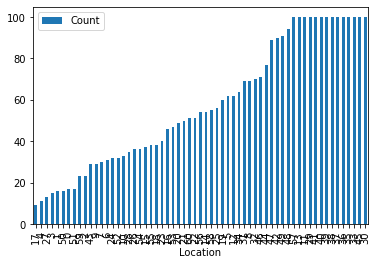

In [45]:
grouped_locations.plot(kind='bar', x='Location', y='Count')

We are also interested in the venue categories that appear, and the frequency of these, as we may wish to clean this up a little to simplify our analysis

In [51]:
grouped_venues = local_venues.groupby(by=['VenueCategory'], as_index = False).count()[['VenueCategory','Location']]
grouped_venues.columns = ['VenueCategory','Count']

exportfile = os.getcwd() + '/data/grouped_venues.csv'
grouped_venues.to_csv(exportfile)

grouped_venues_filtered = grouped_venues[grouped_venues['Count']>10].sort_values(by='Count')

grouped_venues_filtered.shape

(77, 2)

In [53]:
grouped_venues_filtered.tail(20)

,VenueCategory,Count
230,Plaza,42
156,Indian Restaurant,43
67,Cocktail Bar,43
42,Burger Joint,46
290,Theater,47
138,Grocery Store,48
128,Garden,49
19,Bakery,50
123,French Restaurant,56
227,Pizza Place,57


In [60]:
grouped_venues_filtered.plot(kind='bar',x='VenueCategory', y='Count', figsize=(8,4))
plt.show()

<AxesSubplot:xlabel='VenueCategory'>

In [44]:
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

toronto_onehot.head()

,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Rental / Bike Share,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kids Store,Korean Restaurant,Lake,Latin American Restaurant,Lawyer,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Moving Target,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Pastry Shop,Peking Duck Restaurant,Performing Arts Venue,Pet Store,Pharmacy,Piano Bar,Pizza Place,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Social Club,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [45]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head()

,Neighborhood,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Rental / Bike Share,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kids Store,Korean Restaurant,Lake,Latin American Restaurant,Lawyer,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Moving Target,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Pastry Shop,Peking Duck Restaurant,Performing Arts Venue,Pet Store,Pharmacy,Piano Bar,Pizza Place,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Social Club,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.

In [46]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [68]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Lounge,Latin American Restaurant,Skating Rink,Breakfast Spot,Dog Run,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center
1,"Alderwood, Long Branch",Pizza Place,Gym,Pool,Coffee Shop,Skating Rink,Pharmacy,Pub,Sandwich Place,Deli / Bodega,Department Store
2,"Bathurst Manor, Wilson Heights, Downsview North",Coffee Shop,Bank,Ice Cream Shop,Fried Chicken Joint,Sandwich Place,Bridal Shop,Diner,Restaurant,Deli / Bodega,Supermarket
3,Bayview Village,Café,Bank,Japanese Restaurant,Chinese Restaurant,Yoga Studio,Distribution Center,Dim Sum Restaurant,Diner,Discount Store,Dog Run
4,"Bedford Park, Lawrence Manor East",Thai Restaurant,Restaurant,Coffee Shop,Sandwich Place,Italian Restaurant,Juice Bar,Café,Indian Restaurant,Pub,Sushi Restaurant
5,Berczy Park,Coffee Shop,Bakery,Café,Cocktail Bar,Restaurant,Beer Bar,Seafood Restaurant,Cheese Shop,Farmers Market,Bistro
6,"Birch Cliff, Cliffside West",College Stadium,Café,Skating Rink,General Entertainment,Yoga Studio,Dog Run,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store
7,"Brockton, Parkdale Village, Exhibition Place",Café,Breakfast Spot,Bakery,Coffee Shop,Climbing Gym,Burrito Place,Restaurant,Stadium,Italian Restaurant,Intersection
8,"Business reply mail Processing Centre, South C...",Light Rail Station,Garden Center,Pizza Place,Skate Park,Auto Workshop,Burrito Place,Fast Food Restaurant,Farmers Market,Garden,Restaurant
9,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Service,Airport Terminal,Airport Lounge,Boutique,Rental Car Location,Coffee Shop,Boat or Ferry,Sculpture Garden,Airport Gate,Airport Food Court


In [62]:
# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [73]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [74]:
toronto_merged = final

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood', how='right')

toronto_merged

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M3A,North York,Parkwoods,43.753259,-79.329656,2,Park,Food & Drink Shop,Yoga Studio,Dog Run,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Doner Restaurant
1,M4A,North York,Victoria Village,43.725882,-79.315572,0,Hockey Arena,Pizza Place,Portuguese Restaurant,French Restaurant,Intersection,Coffee Shop,Drugstore,Donut Shop,Doner Restaurant,Dog Run
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,1,Coffee Shop,Bakery,Pub,Park,Breakfast Spot,Café,Theater,Spa,Shoe Store,Restaurant
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,1,Clothing Store,Accessories Store,Boutique,Furniture / Home Store,Event Space,Miscellaneous Shop,Coffee Shop,Women's Store,Vietnamese Restaurant,Airport Service
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,1,Coffee Shop,Diner,Yoga Studio,Smoothie Shop,Mexican Restaurant,Portuguese Restaurant,Bar,Bank,Beer Bar,Sushi Restaurant
6,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353,3,Fast Food Restaurant,Doner Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Donut Shop,Falafel Restaurant
7,M3B,North York,Don Mills,43.745906,-79.352188,1,Gym,Beer Store,Japanese Restaurant,Coffee Shop,Restaurant,Chinese Restaurant,Sandwich Place,Bubble Tea Shop,Bike Shop,Sporting Goods Shop
13,M3C,North York,Don Mills,43.725900,-79.340923,1,Gym,Beer Store,Japanese Restaurant,Coffee Shop,Restaurant,Chinese Restaurant,Sandwich Place,Bubble Tea Shop,Bike Shop,Sporting Goods Shop
8,M4B,East York,"Parkview Hill, Woodbine Gardens",43.706397,-79.309937,1,Pizza Place,Gym / Fitness Center,Bank,Intersection,Athletics & Sports,Gastropub,Pharmacy,Pet Store,Café,Drugstore
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,1,Clothing Store,Coffee Shop,Café,Japanese Restaurant,Italian Restaurant,Cosmetics Shop,Bubble Tea Shop,Theater,Diner,Hotel


In [76]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters